In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import squidpy as sq
#import scanpy as sc
import pandas as pd
import os
from PIL import Image
import imagecodecs
import tifffile as tff
from pyometiff import OMETIFFReader
#import seaborn as sns
#import geopandas as gpd
from shapely.geometry import Polygon

#from sklearn.mixture import GaussianMixture
#from scipy.stats import norm

import pickle
import ssam
import time

# Def Functions

In [2]:
def read_transcript_file(data_dir,sample_dir):
    #nucleus_bound=pd.read_csv(os.path.join(data_dir,sample_dir,'nucleus_boundaries.csv.gz'))
    #cell_bound=pd.read_csv(os.path.join(data_dir,sample_dir,'cell_boundaries.csv.gz'))
    transcripts=pd.read_csv(os.path.join(data_dir,sample_dir,'transcripts.csv.gz'))   
    transcripts=transcripts[~transcripts['feature_name'].str.contains('BLANK|NegControl',regex=True)] 
    #cells=pd.read_csv(os.path.join(data_dir,sample_dir,'cells.csv.gz'))

    return transcripts
    

def standardise_transcript_locations(transcripts,metadata):
    ## Extract pixel width and height
    pixel_width=np.float64(metadata['PhysicalSizeX'])
    pixel_height=np.float64(metadata['PhysicalSizeY'])

    std_transcripts=transcripts.copy()

    for coord_col in ['x_location','y_location','z_location']:
        std_transcripts[coord_col]=(std_transcripts[coord_col]-std_transcripts[coord_col].min())*pixel_width*2
    
    return std_transcripts


def read_ome_tiff(slide_type,data_dir,sample_dir):
    if slide_type=='focus':
        fn=os.path.join(data_dir,sample_dir,'morphology_focus.ome.tif')

    if slide_type=='mip':    
        fn=os.path.join(data_dir,sample_dir,'morphology_mip.ome.tif')

    if slide_type=='z_stack': 
        fn=os.path.join(data_dir,sample_dir,'morphology.ome.tif')
        
    reader = OMETIFFReader(fpath=fn)
    img_array,metadata,xml_metadata=reader.read()

    return img_array,metadata,xml_metadata


def calculate_ssam_requirements(transcripts):
    ## Calculate widht and height of the slide
    xmin,xmax=transcripts['x_location'].min(), transcripts['x_location'].max()
    ymin,ymax=transcripts['y_location'].min(), transcripts['y_location'].max()
    zmin,zmax=transcripts['z_location'].min(), transcripts['z_location'].max()

    width = int(xmax-xmin)
    height = int(ymax-ymin)
    depth = int(zmax-zmin)

    ## Extract list of genes
    grouped=transcripts.groupby('feature_name').agg(list)
    genes=list(grouped.index)

    ## Extract all coordinates of transcripts for each gene
    coord_list=[]
    for gene in grouped.index:
        coord_list.append(transcripts[transcripts['feature_name']==gene][['x_location','y_location']].values)

    return genes,coord_list,width,height
    

def create_temp_output_dir(proc_dir,panel,sample_name):
    ## Create prcoessed data output directory if not existing yet
    if not os.path.isdir(proc_dir):
        os.makedirs(proc_dir)
        print(f'Created directory: {proc_dir}')
    
    
    ## Create output directory for sample if not existing yet
    sample_dirname='_'.join([panel.split('_')[-1],sample_name.split('__')[2]])
    sample_path=os.path.join(proc_dir,sample_dirname)

    if not os.path.isdir(sample_path):
        os.makedirs(sample_path)
        print(f'Created directory: {sample_path}')
       
    
    return sample_path


## Setup function for calculating elapsed time
def print_elapsed_time(start,stop):
    # Calculate the elapsed time in seconds
    elapsed_seconds=stop-start
    
    # Convert elapsed time to hours and minutes
    elapsed_minutes, elapsed_seconds = divmod(int(elapsed_seconds), 60)
    elapsed_hours, elapsed_minutes = divmod(elapsed_minutes, 60)
    
    # Print the result in the desired format
    return(f"{elapsed_hours} hours: {elapsed_minutes} minutes: {elapsed_seconds} seconds")    


## From the SSAM paper:
# "SSAM applies two thresholds for local maxima selection: (1) Minimum expression threshold for a single gene defined as the height of a single Gaussian kernel 
# to avoid regions with signal from only the Gaussian tail which also corresponds to the position of the observable drop in the histograms of gene expression"

## Detection of sudden drop in the expression histograms:
#  1. First part of the histogram roughly corresponds to an exponential-sigmoid decay (these are the tails of the fitted KDE curves adding up), 
#     until the sudden drop (real expression signal starts)
#  2. Differentiate the histogram curve (d(log10(y))/dx) -> the second part with real signal does not follow the exponential decay curve -> has a greater variance
#     compared to first part
#  3. Fit a sigmoid curve to the differentiated data -> the first part closely fits, but where real expression signal starts there is a significant drop + usually the
#.    points after this show a greater variance around the fitted curve => MAIN TASK: get the x-coordinate of the first significant drop (Step 4 and 5 will do that)
#  4. Extract the squared residual to the fitted curve + differentiate them to smooth them a bit -> task is to determine the x-coordinate where there is a significant
#     jump the in the resiudals
#  5. Calculate ratio of data point "Xi" to the running variance (var(X3:i)) in the smoothed residual data in a loop=> in the first part of the curve the variance is 
#     relatively steady, therefore the jump in the residuals will be a high number this way => extract the x-coordinate (==KDE estimated minimum expression of a gene) with argmax
#. 6. Collect estimates of minimum expression threshold for a single gene and get the mode of the estimates as inimum expression threshold for a single gene 
#.    => the estimates should be almost equal for each gene
#     => for genes where the sudden drop is not pronouncedm this script may not find the correct value -> majority of the genes have a significant drop and a reliable estimate ->
#        by taking the mode of the estimates we only take the reliable values into account
#.    

def find_local_max_min_expr_thr(ds,genes,plot):
    '''
    params:
    @ds: SSAM dataset 
    @genes: list of genes (or any subset of them) that were used for the initialization of SSAM dataset
    @plot: when True, plot 1.histograms of gene expression (KDE estimated)
            2. Differentiated histograms + fitted sigmoid curve
            3. Smoothed squared resiudals to the sigmoid curve, where the first non-inf maximum value corresponds to the minimum expression threshold
    '''
    import math
    from scipy.optimize import curve_fit
    from scipy import stats
    from statistics import mode


    def sigmoid(x, L ,x0, k, b):
        y = L / (1 + np.exp(-k*(x-x0))) + b
        return (y)

    ## Get vector field and transpose it in order to loop over it more easily
    vector_field_array=np.transpose(ds.vf, (3, 0, 1, 2))

    ## Set up parameters for plotting
    nplots=len(genes)#vector_field_array.shape[0]
    ncols=3
    nrows=math.ceil(nplots/ncols)

    if plot==True:
        fig=plt.figure(figsize=(ncols*5,nrows*4))
        fig2=plt.figure(figsize=(ncols*5,nrows*4))
        fig3=plt.figure(figsize=(ncols*5,nrows*4))

    ## First element of the histogram bin list (==KDE estimated expression)  where the running variance in step 5. is getting estimated from.
    #  - var_est_start>=2, as you need at least two numbers to calcuate variance
    #. - Make sure, that hist[var_est_start+1] is before the sudden drop in the expression histograms
    #. - Setting this too high -> you might miss the minimum expression threshold for a single gene 
    var_est_start=3
    
    ## List to collect minimum expression threshold estimates for all genes
    l=[]
    
    ## Number of bins for the KDE estimated gene expression histogram 
    hist_bins=500

    ## Loop over the KDE estimated vector field of each gene and get their histogram
    #   => looking for a sudden drop in the vector field (==estimated gene expression) histogram
    for n,gene in zip(range(nplots),genes):
        
        ## 1. Extract non-zero gene expression histogram => IMPORTANT: keep bin number high (~500) so the sigmoid curve can fit the initial "knee" in the differentiated curve!
        gene_vector_field=vector_field_array[n].flatten()
        hist,bins=np.histogram(gene_vector_field[gene_vector_field>0],bins=hist_bins)
        ## Set 0s to 1 to avoid nans-> will be taking the log10 values in next step
        hist[hist==0]=1 

        ## 2. Take the differential of the log10 histogram-curve values
        diff=np.diff(np.log10(hist))/np.diff(bins[1:])
        x_data=bins[1:-1]
        y_data=diff

        ## 3. Fit the sigmoid curve to the differentiated histogram curve          
        p0 = [max(y_data), np.median(x_data),1,min(y_data)] # this is an mandatory initial guess
        params, covariance = curve_fit(sigmoid, x_data, y_data,p0, method='lm',maxfev=10000)
        # Parameters a, b, and c for the fitted sigmoid curve + fit curve to data
        L ,x0, k, b = params
        y_fit = sigmoid(x_data, L ,x0, k, b)

        ## 4. Calculate squared residuals to the fitted sigmoid curve + differentiate them once to smooth the initial hump coming from the "knee" in the residuals a bit
        std=stats.zscore((y_fit-y_data)**2)
        diff_std=np.abs(np.diff(std))

        ## 5. Calculate Xi/var(X3:i) ratio in a running manner + replace 'inf' values with nan (possible inf,-inf coming in the first couple of value, where the running variance
        #     is unstable due to the sigmoid curve not fitting to the knee part here exactly, but the next jump in the mvg_var_ratio corrsponds to the first real)
        mvg_var_ratio=np.array([(diff_std[i]/np.std(diff_std[var_est_start:i])) for i in range(var_est_start,len(diff_std))])
        mvg_var_ratio[np.isinf(mvg_var_ratio)]=np.nan
        
        local_max_min_expr_thr_est=x_data[np.nanargmax(mvg_var_ratio)+var_est_start+1]        
        l.append(local_max_min_expr_thr_est)
        
        if plot==True:
            ## KDE estimated gane expression histograms
            ax=fig.add_subplot(nrows,ncols,n+1)
            ax.hist(gene_vector_field,density=True,bins=int(hist_bins/2));

            ## Differentiated histogram curves + fitted sigmoid curve
            ax2=fig2.add_subplot(nrows,ncols,n+1)
            ax2.plot(x_data,diff)
            ax2.plot(x_data,y_fit)
            
            ## Smoothed resiudals of the fitted sigmoid curve
            ax3=fig3.add_subplot(nrows,ncols,n+1)
            ax3.scatter(x_data[+var_est_start+1:],mvg_var_ratio,s=1.5)
        
            ax.set_yscale('log')
            
            for a in [ax,ax2,ax3]:
                a.set_title(gene)
                a.axvline(local_max_min_expr_thr_est,alpha=0.3)
    
    ## 6. Get the minimum expression threshold as the mode of the minimum expression threshold estimates of the genes, 
    #     Get the mode of the distribution to only consider genes with a significant drop not all of the estimates are correct
    local_max_min_expr_thr=mode(l)

    ## If there is a bimodal distribution of estimates, ask the user to check manually on the plots as the automatic detection is not reliable
    hist_,bins_=np.histogram(l)
    bimodal_thr=0.2
    hist_=-np.sort(-hist_)
    if hist_[1]/hist_[0]>bimodal_thr:
        raise Exception('Automatic detection of minimum gene expression threshold not reliable! Please run find_local_max_min_expr_thr()function with plot=True parameter and manually check expressions histograms for minimum gene expression threshold! Example for drop in histograms: SSAM paper, Suppl.Fig3A,17A,28A. If ')

    if plot==True:
        fig4,ax4=plt.subplots(1,1,figsize=(8,5))
        ax4.hist(l,bins=30)
        ax4.text(np.mean(l),ax4.get_ylim()[1]*0.8,'Minimum gene expression threshold mode:\n'+str(round(local_max_min_expr_thr,4)))

        fig.suptitle('KDE estimated gene expression')
        fig2.suptitle('Differentiated histogram curves + fitted sigmoid curve')
        fig3.suptitle('Smoothed residuals of the fitted sigmoid curve')
        fig4.suptitle('Minimum gene expression threshold estimate distribution')

    return local_max_min_expr_thr
  


# Run SSAM

In [30]:
data_dir="/Volumes/T7/Plaque_Xenium_data"
data_dir="/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/"
proc_dir='../xenium_data/processed_data/ssam_analysis'

## Drop scratch folders that start with "._"
panel_dir=[f for f in os.listdir(data_dir) if ('Panel' in f and '._' not in f)]
panel_dir.sort()

start=time.time()
for panel in panel_dir[0:1]:
    panel_dir=os.path.join(data_dir,panel)
    sample_name_list=os.listdir(panel_dir)
    sample_name_list.sort()

    ## Loop over all samples in a batch
    for sample_name in sample_name_list[0:]:
        sample_dir=os.path.join(data_dir,panel,sample_name)
        #print(sample_name)
        if os.path.isdir(sample_dir) and 'P3_D' in sample_dir:
            #sample_start=time.time()
            #t=print_elapsed_time(start,sample_start)
            #print('Time elapsed since beginning:',t)

            ## Load DAPI fluorescent-stained slide image
            # Select one slide_type ('mip'/'focus'/z_stack') file to load and 
            slide_type='mip'
            img_array,metadata,xml_metadata=read_ome_tiff(slide_type,data_dir,sample_dir)
            del img_array
            #print('Slide loaded')
            
            ### LOAD TRANSCRIPTS DATA + PREPARE DATA FOR SSAM DATASET CREATION
            transcripts=read_transcript_file(data_dir,sample_dir)
            std_transcripts=standardise_transcript_locations(transcripts,metadata)
            genes,coord_list,width,height=calculate_ssam_requirements(std_transcripts)
            ds=ssam.SSAMDataset(genes, coord_list, width, height)

            
            ### RUN KERNEL DENSITY ESTIMATION
            kde_tmp_output_dir=create_temp_output_dir(proc_dir,panel,sample_name)        
            ## Kde parameters
            kde_start=time.time()    
            kde_bw=2.5 # => 2.5 ~ 10 um sized cells -> experiment in range of 2-4 
            kde_sampling_dist=1 # Sampling distance in micrometers

            print('Starting KDE')
            analysis=ssam.SSAMAnalysis(ds, ncores=-1, verbose=True, save_dir=kde_tmp_output_dir)
            #analysis.run_kde(bandwidth=kde_bw,sampling_distance=kde_sampling_dist,use_mmap=False)
            analysis.run_fast_kde(bandwidth=kde_bw,sampling_distance=kde_sampling_dist,re_run=True,use_mmap=False)

            kde_stop=time.time()  
            t=print_elapsed_time(kde_start,kde_stop)
            print('KDE runtime:',t)

            
            ### DOWNSAMPLING VIA FINDING LOCAL MAXIMA FOR FASTER COMPUTATION
            ##  Local maxima parameters
            local_max_search_size=3 # Size of square used for search. Has to be odd number!
            
            print('Finding minimum gene expression threshold')
            local_max_min_expression=find_local_max_min_expr_thr(ds,genes,plot=False)  
            local_max_min_norm=local_max_min_expression

            '''            
            print('Find local maxima for downsampling')
            down_start=time.time()
            analysis.find_localmax(search_size=local_max_search_size, min_norm=local_max_min_norm, min_expression=local_max_min_expression)
            down_stop=time.time()
            t=print_elapsed_time(down_start,down_stop)
            print('Downsampling runtime:',t)


            ### NORMALIZE VECTORS
            analysis.normalize_vectors()


            ### CLUSTERING OF EXPRESSION VECTORS
            clust_vec_min_cluster_size=1 # can be increased for only robust types... or reduced for rare
            clust_vec_pca_dims=50 # perhaps this should be set to the tSNE and UMAP components?
            clust_vec_resolution=0.3 # this is the Louvain resolution. Higher means fewer clusters.
            clust_vec_metric='correlation'

            print('Clustering expression vectors')
            cluster_start=time.time()
            analysis.cluster_vectors(min_cluster_size=clust_vec_min_cluster_size,
                                     pca_dims=clust_vec_pca_dims,
                                     resolution=clust_vec_resolution,
                                     metric=clust_vec_metric,
                                     subclustering=True)
            
            cluster_stop=time.time()
            t=print_elapsed_time(cluster_start,cluster_stop)
            print('Clustering runtime:',t)
            
            ### MAPPING CELLTYPES
            print('Mapping celltypes')
            map_start=time.time()
            analysis.map_celltypes()
            cluster_stop=time.time()
            t=print_elapsed_time(cluster_start,cluster_stop)
            print('Celltype mapping runtime:',t)
            
            '''

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'
Created directory: ../xenium_data/processed_data/ssam_analysis/Panel1_P4_D
Starting KDE
Processing gene CTSB...
Processing gene SPP1...
Processing gene CTSD...
Processing gene VIM...Processing gene LYZ...
Processing gene FN1...Processing gene APOE...

Processing gene CD68...Processing gene CD36...
Processing gene MMP12...

Processing gene PKM...Processing gene COL1A2...
Processing gene FABP5...
Processing gene SELENOP...Processing gene TPM1...Processing gene COL3A1...

Processing gene LUM...Processing gene MYL9...Processing gene NPIPB5...Processing gene HMGN2...Processing gene MYH11...Processing gene MMP9...

Processing gene CD14...





Processing gene DCN...Processing gene LRP1...
Processing gene LGALS3...Processing gene DSTN...Processing gene CCL18...Processing gene TAGLN...Processing gene ANXA1...Processing gene CCL2...
Processing gene ITGAX...Processing gene HTRA1...
P

/tmp/ipykernel_106883/3780694334.py:131: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_106883/3780694334.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  mvg_var_ratio=np.array([(diff_std[i]/np.std(diff_std[var_est_start:i])) for i in range(var_est_start,len(diff_std))

/tmp/ipykernel_106883/3780694334.py:131: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_106883/3780694334.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  mvg_var_ratio=np.array([(diff_std[i]/np.std(diff_std[var_est_start:i])) for i in range(var_est_start,len(diff_std))

0.025593393939310486

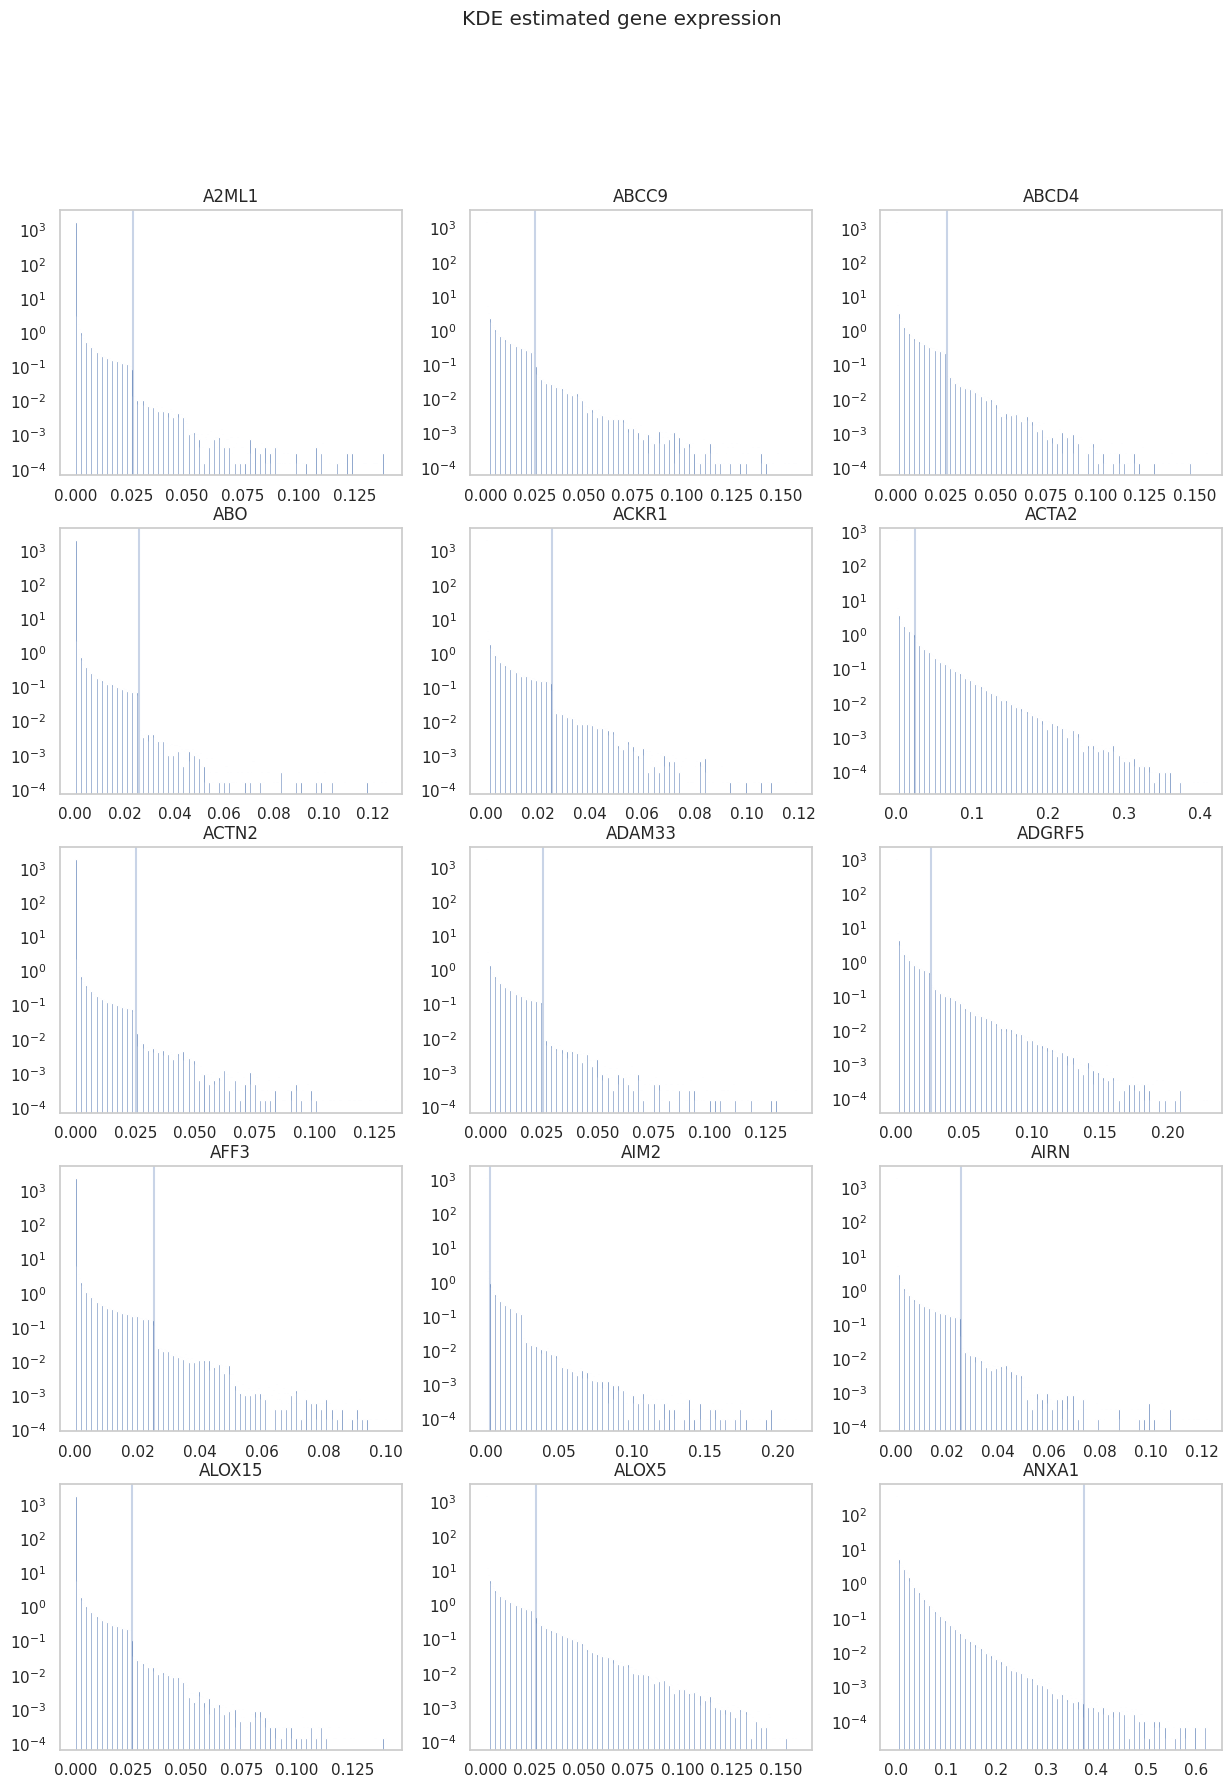

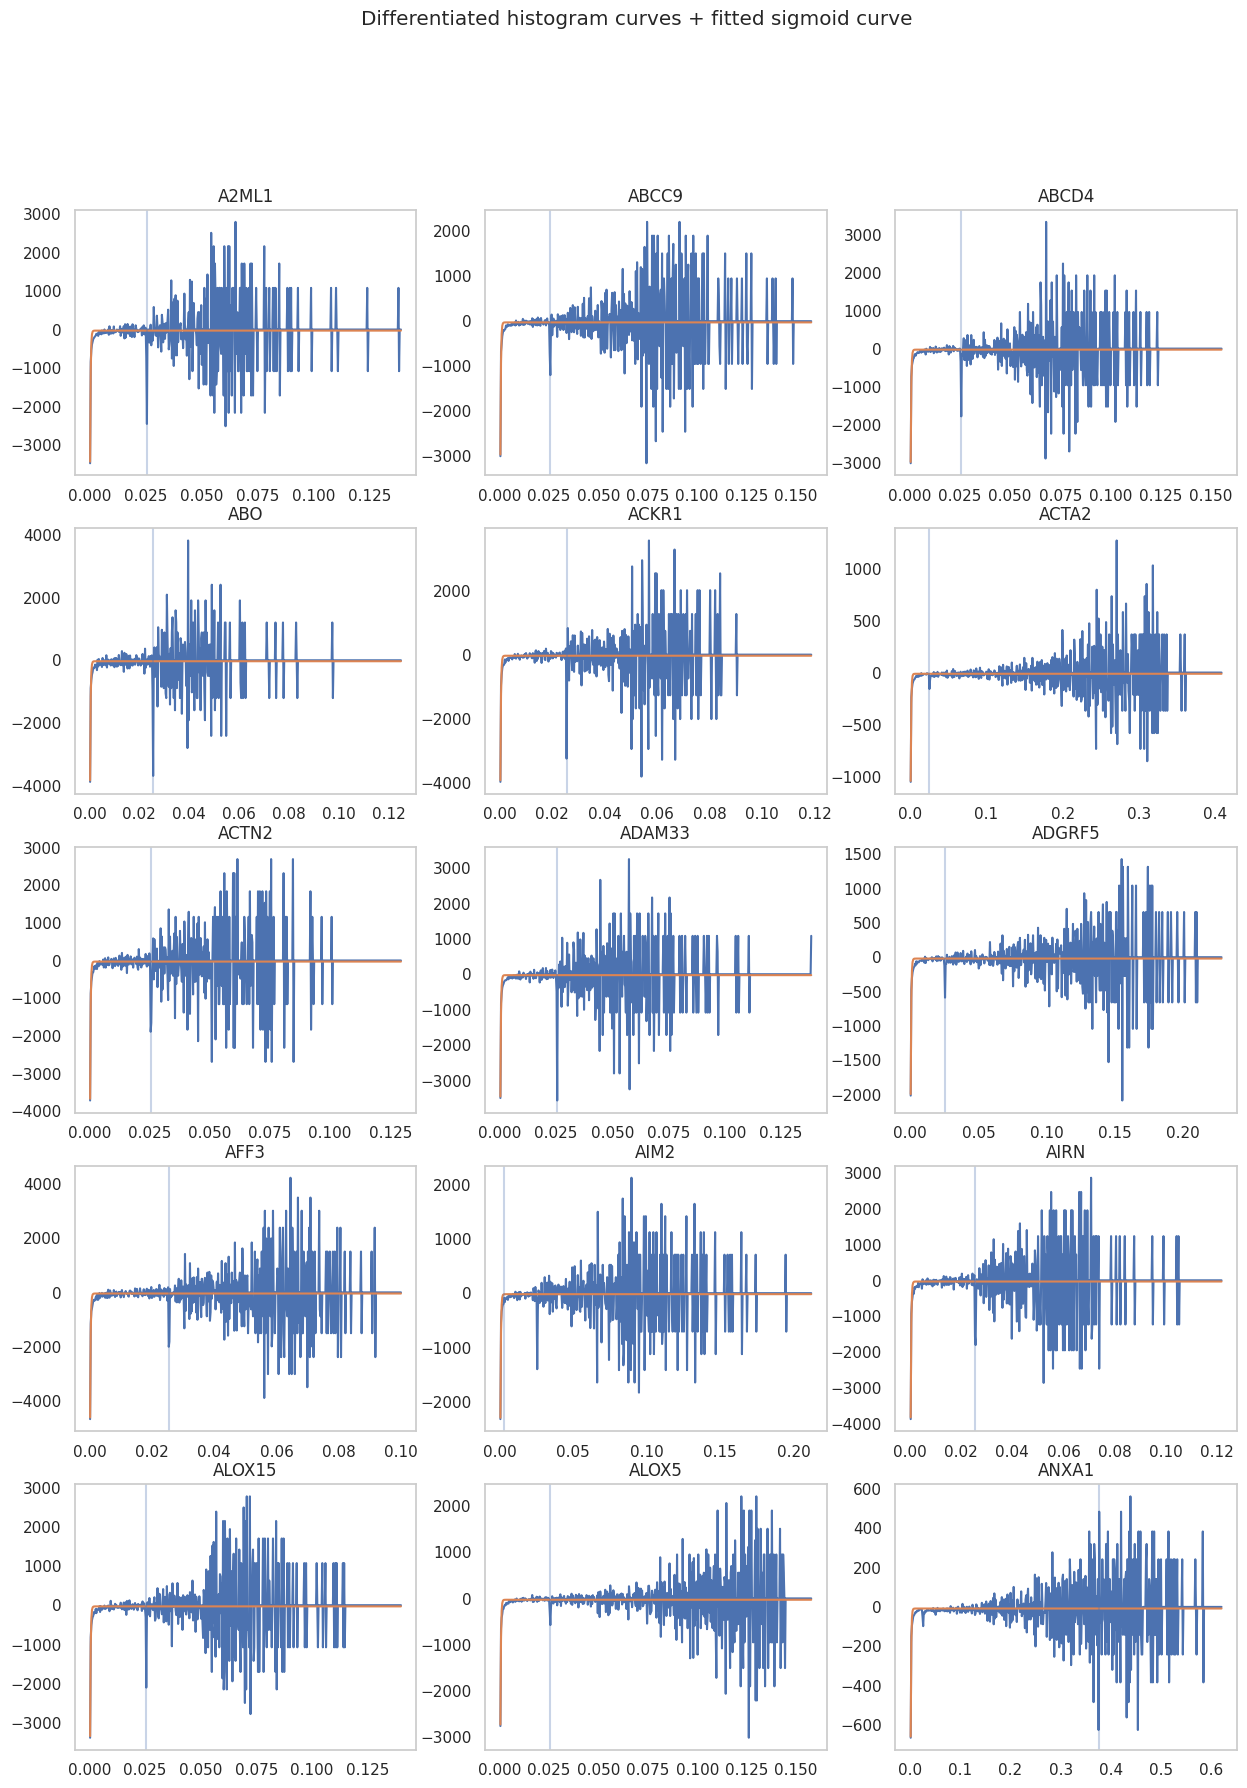

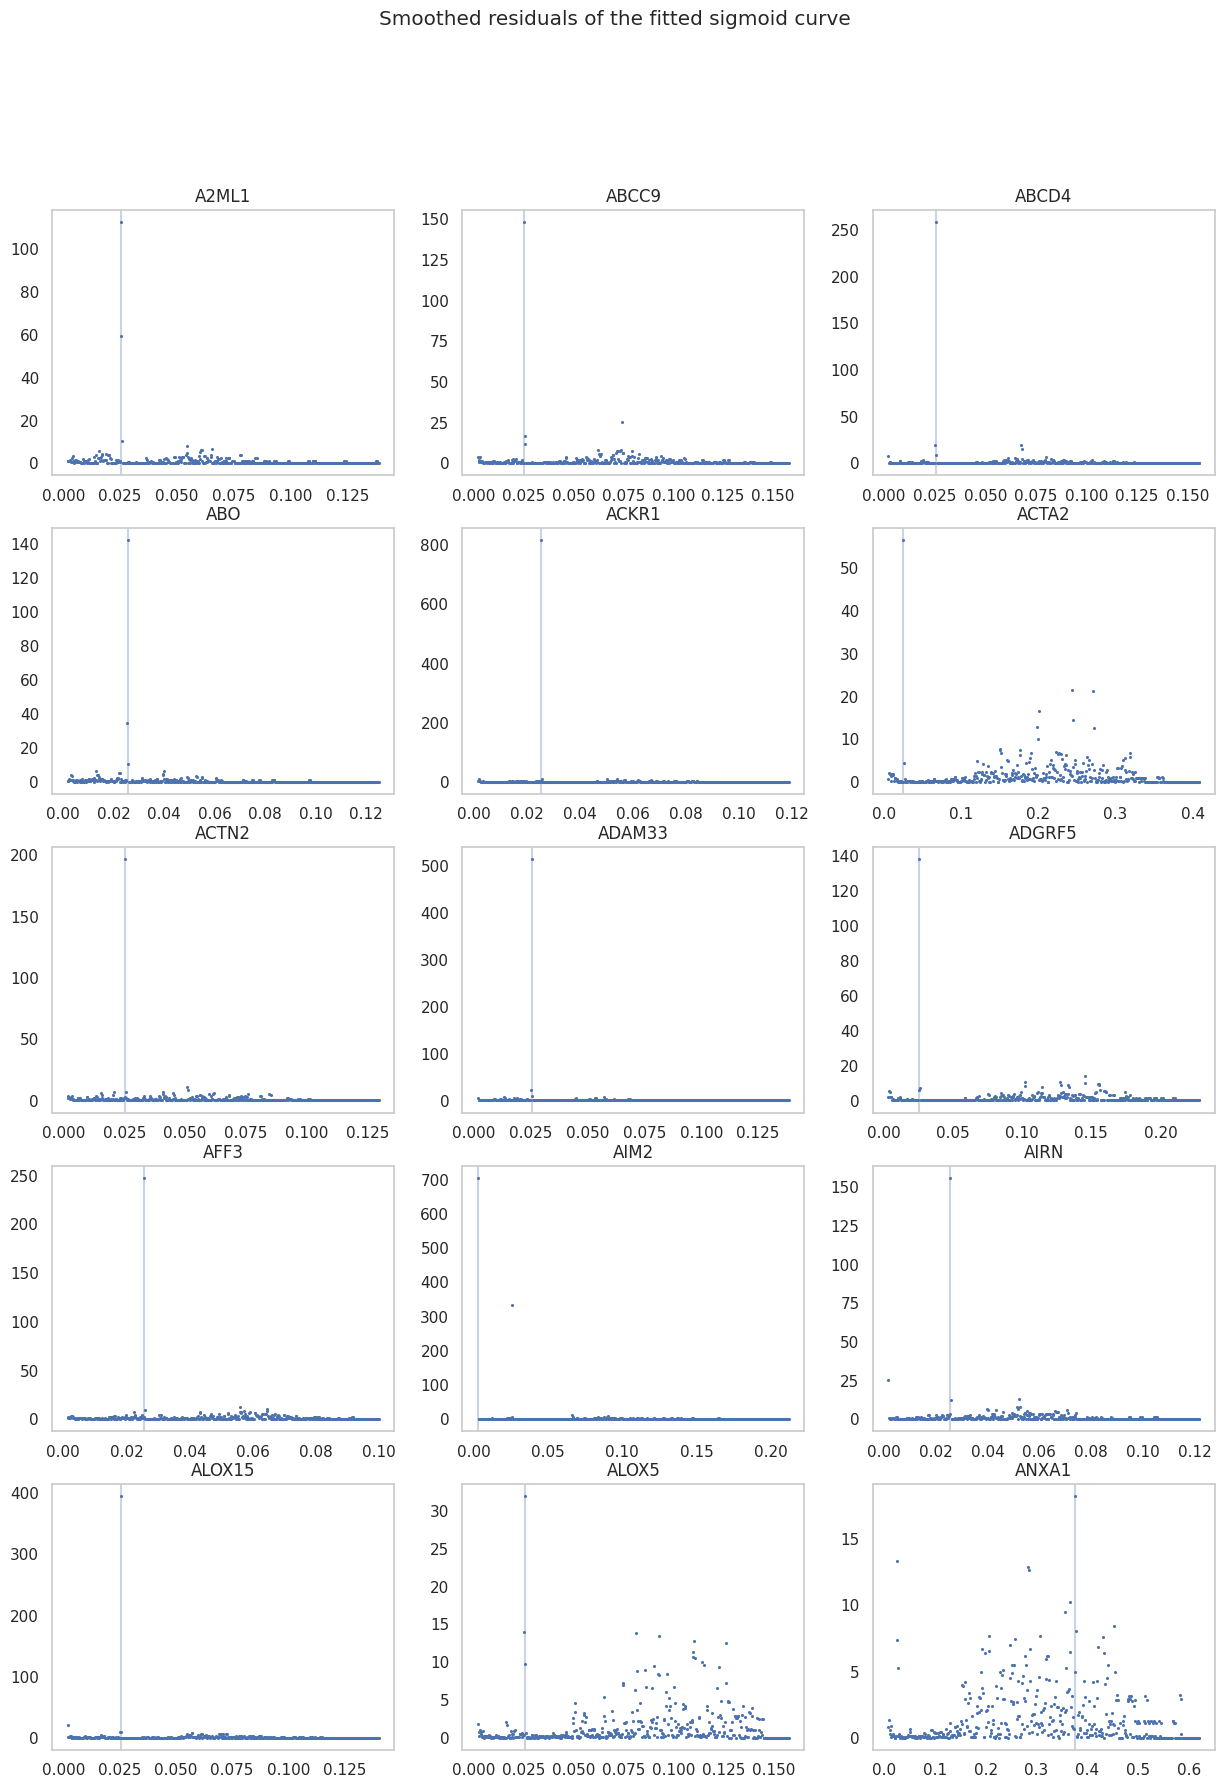

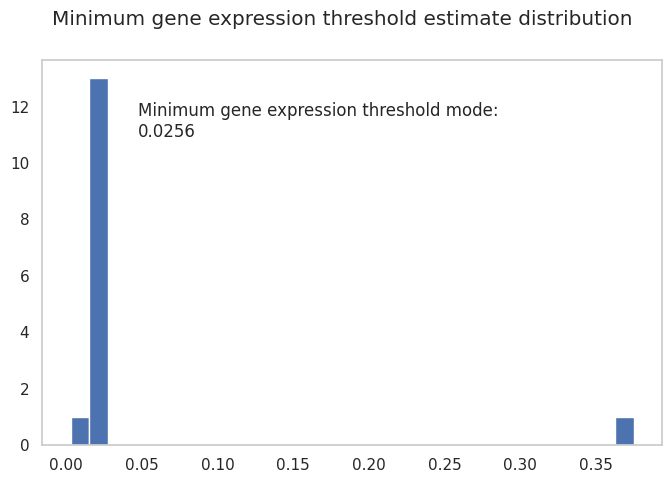

In [32]:
find_local_max_min_expr_thr(ds,genes[:15],plot=True)  

(0.0, 0.3)

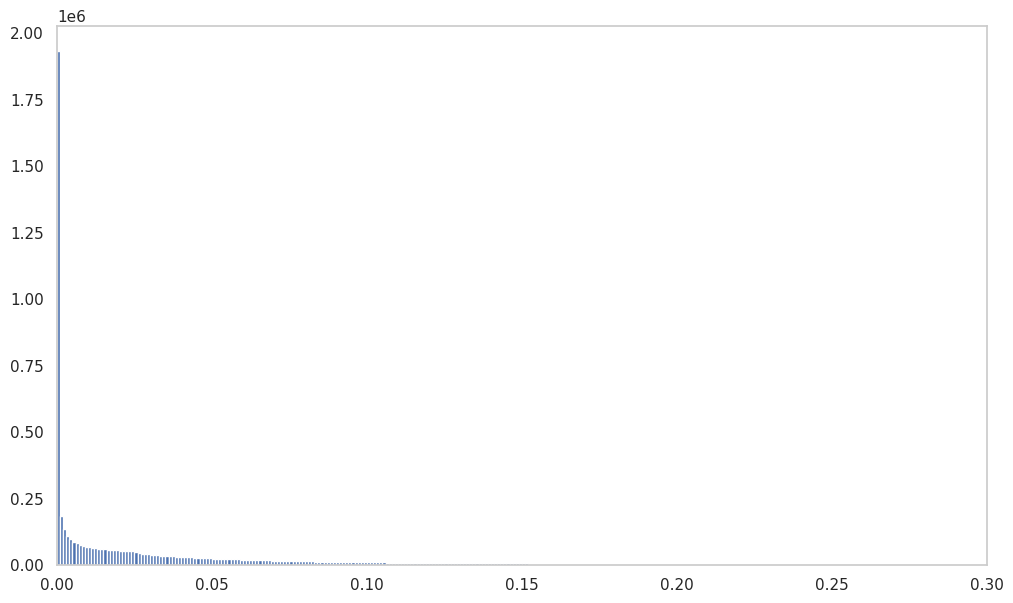

In [29]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
uplimit=0.3 #np.max(ds.vf_norm)
vf_norm=ds.vf_norm.flatten()[(ds.vf_norm.flatten()>0)&(ds.vf_norm.flatten()<uplimit)]
ax.hist(vf_norm,bins=300,log=False)
#ax.set_yscale('log')
ax.set_xlim(0,uplimit)
#ax.set_ylim(10e3,)

In [ ]:
filter_params = {
    "block_size":61,
    "method": "gaussian",
#     "mode": "constant",
    "offset": 0.05
}

analysis.filter_celltypemaps(min_norm = 'local', 
                             filter_params=filter_params, 
                             min_r=0.3,
                             fill_blobs=True, 
                             min_blob_area=30)

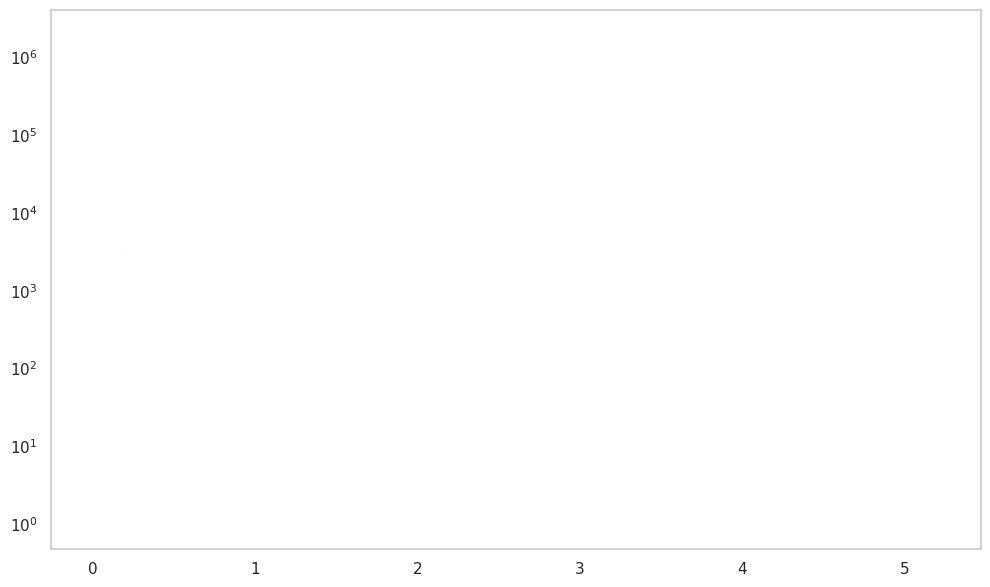

In [8]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
vf_norm=ds.vf_norm.flatten()[ds.vf_norm.flatten()>0]
ax.hist(vf_norm,bins=5000)
ax.set_yscale('log')
#ax.set_xlim(0,1)
#ax.set_ylim(10e2,10e4)



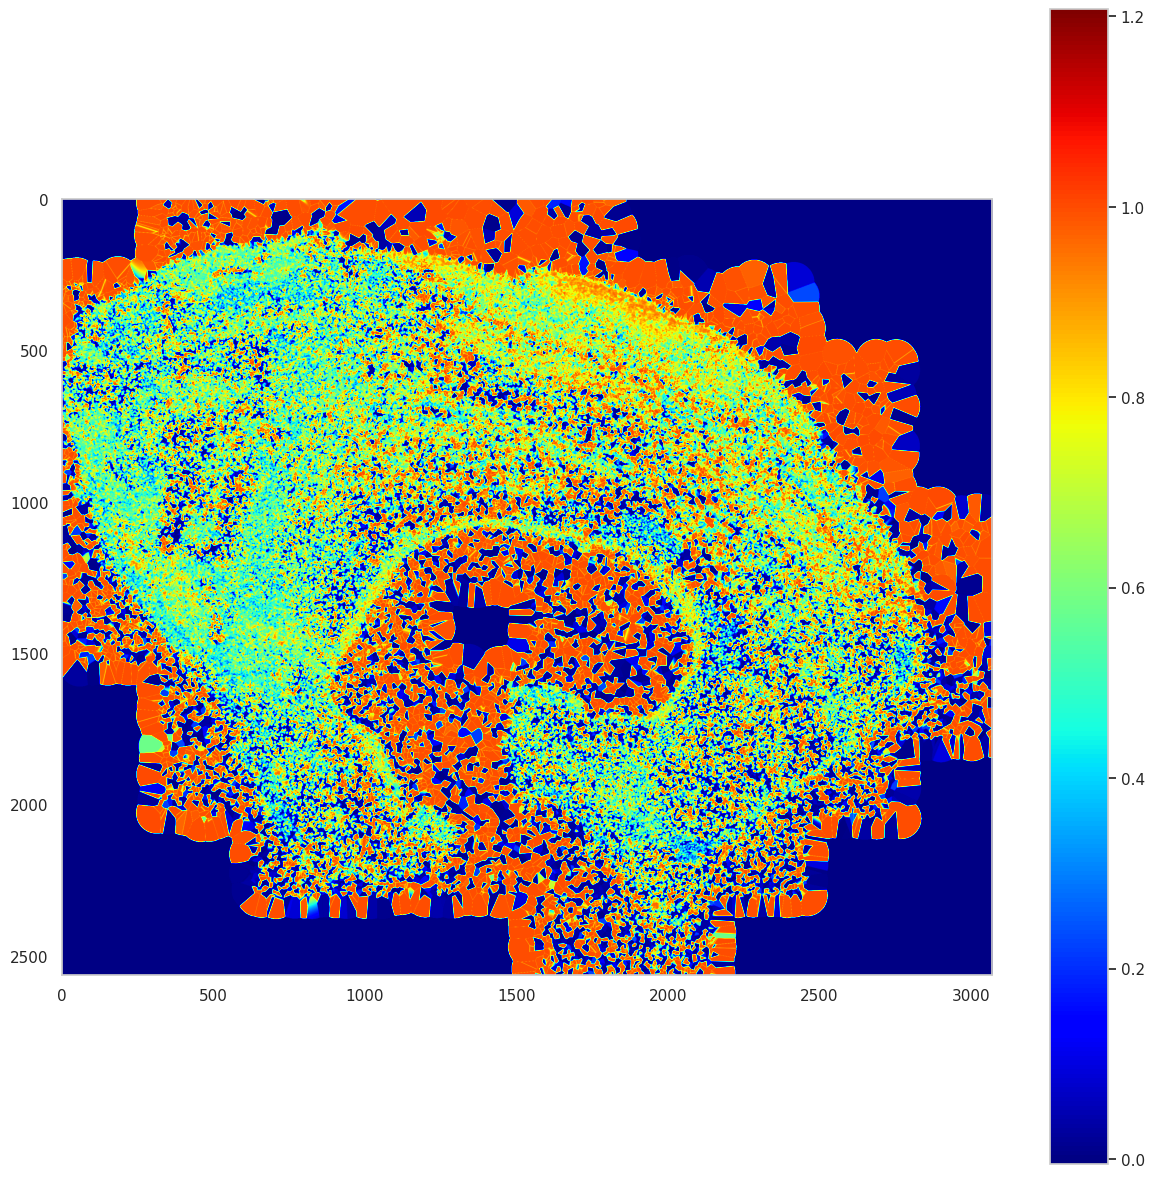

In [23]:
plt.figure(figsize=(15,15))

plt.imshow(ds.max_correlations[:,:,0],cmap='jet')
plt.colorbar()

In [13]:
#plt.figure(figsize=[20, 20])
#ds.plot_localmax(cmap="viridis", rotate=1, s=0.1)
#ds.plot_l1norm(cmap="viridis", rotate=1)
ds.plot_expanded_mask()

AttributeError: 'SSAMDataset' object has no attribute 'expanded_mask'

<Figure size 2000x2000 with 0 Axes>

/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


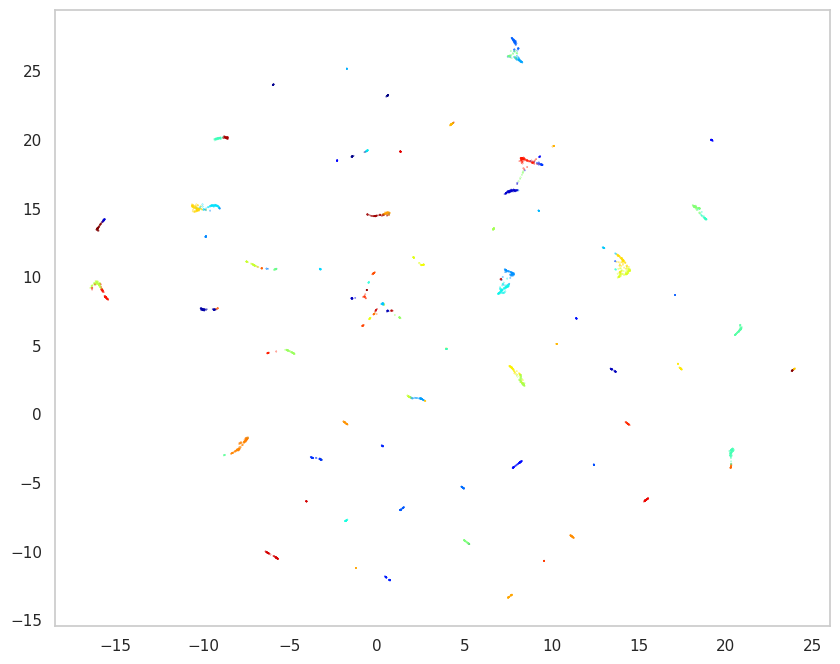

In [18]:
plt.figure(figsize=[10, 8])
ds.plot_umap(pca_dims=50,s=0.05)

## ENd

/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/ssam/__init__.py:276: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(self.local_maxs[dim0], self.local_maxs[dim1], s=s, c=c, cmap=cmap)


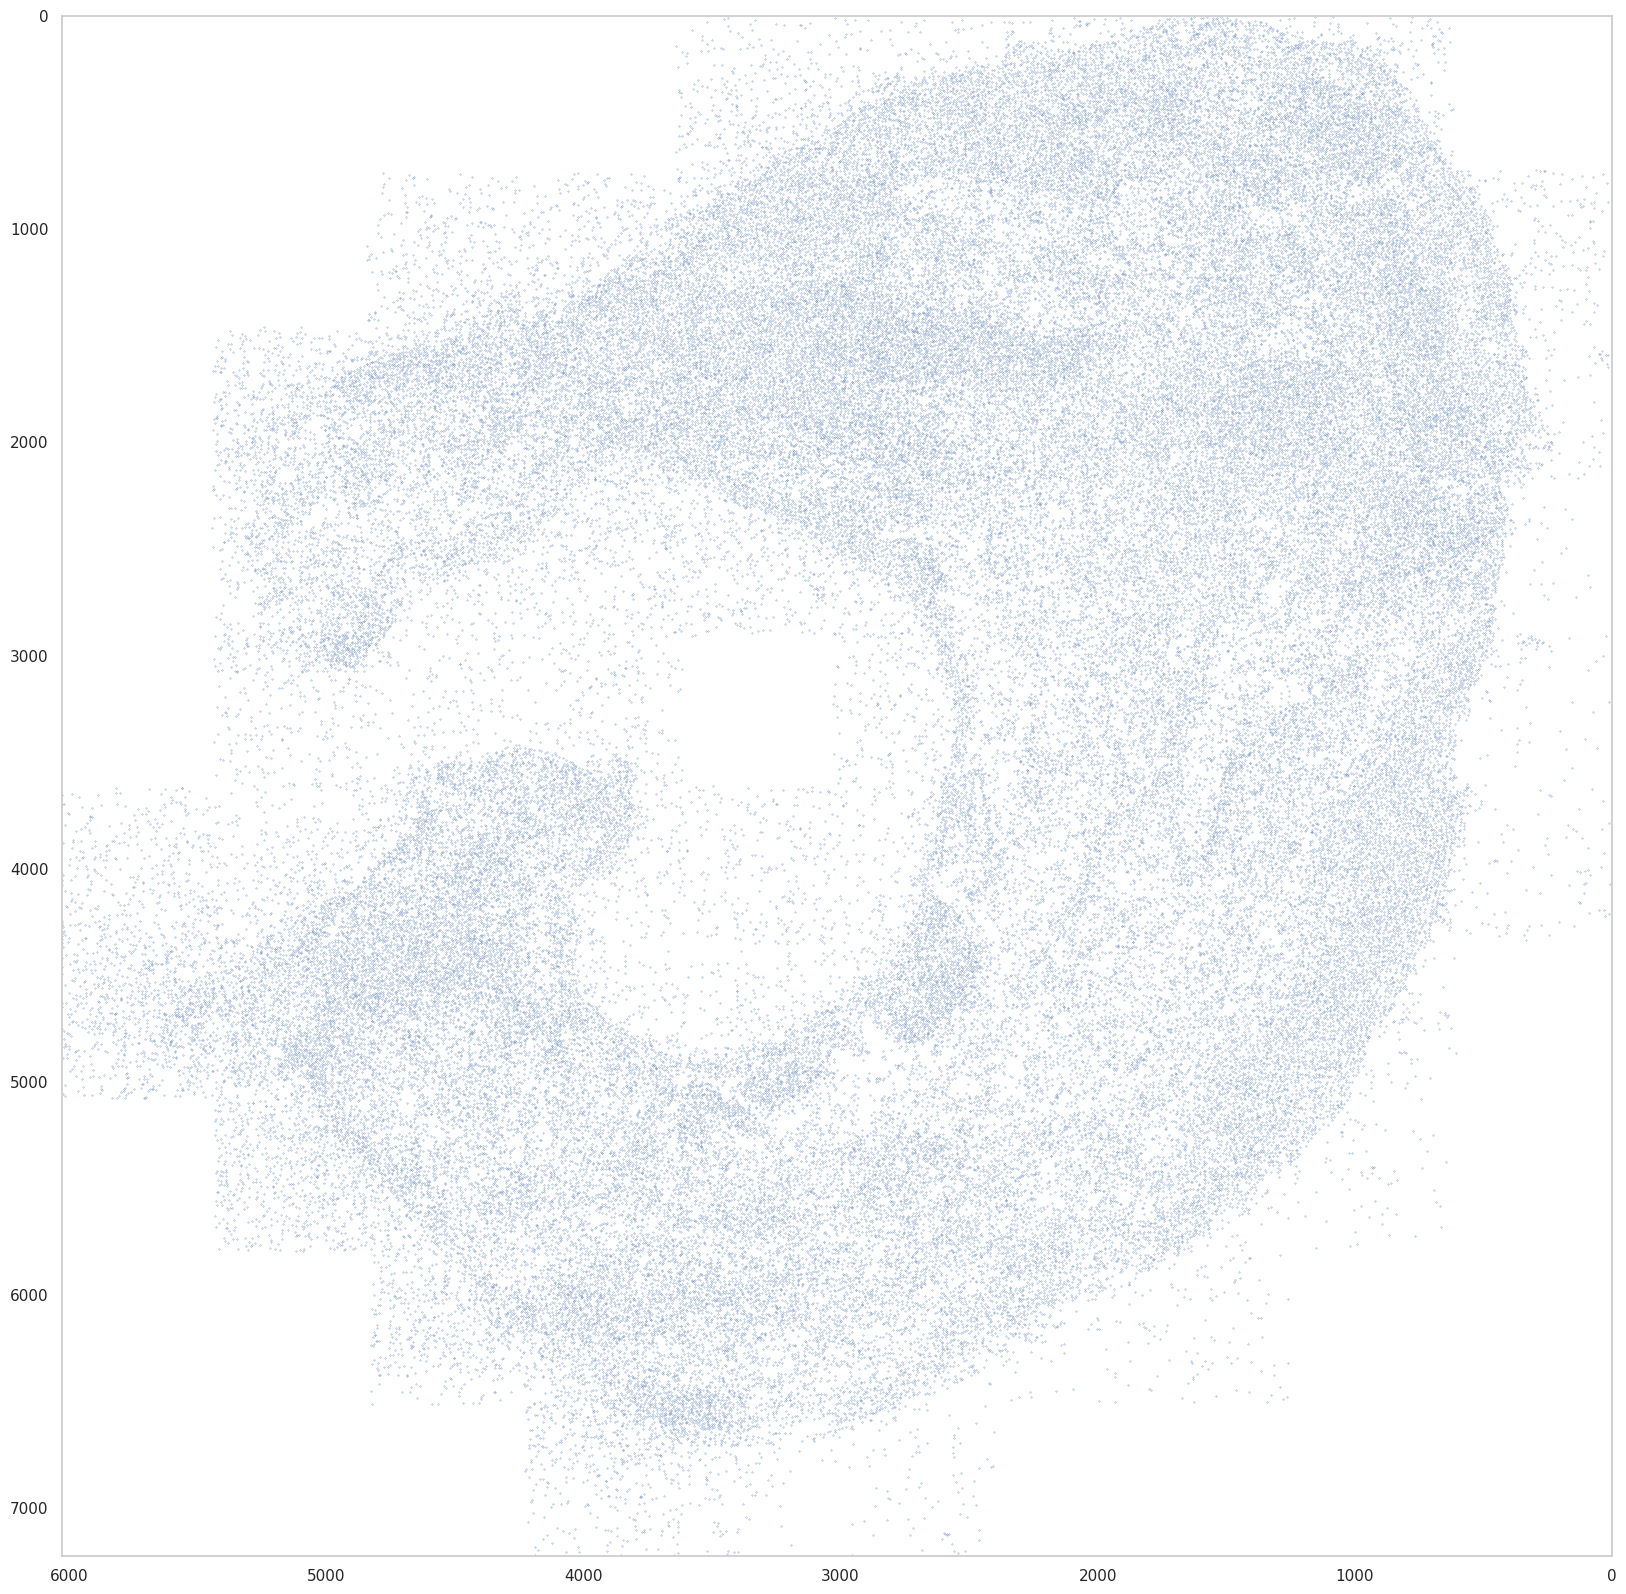

In [20]:
plt.figure(figsize=[20, 20])
#ds.plot_l1norm(cmap='viridis', rotate=0)


In [66]:
height

1535